<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/1_Patent_BERT241009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --target=$my_path pycountry
!pip install pycountry
import pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.5 MB/s eta 0:00:00


In [ ]:
# @article{patent_bert,
#   author = "Jieh-Sheng Lee and Jieh Hsiang",
#   title = "{PatentBERT: Patent classification with fine-tuning a pre-trained BERT model}",
#   journal = "World Patent Information",
#   volume = "61",
#   number = "101965",
#   year = "2020",
# }

In [ ]:
# 필요한 라이브러리 설치
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install joblib


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:


# GitHub raw URL
data_url = 'https://raw.githubusercontent.com/deep1003/deep1003/master/patent_industry.csv'

# 데이터 로드
df = pd.read_csv(data_url, delimiter=';')  # Try ',' or ';'

# 데이터 확인
print(df.head())
print(df.columns)

   appln_id  earliest_filing_year person_ctry_code cpc_class_symbol  \
0  50011164                  1994               US     G01S   7/417   
1  50358660                  1995               US     Y10S 706/906   
2  50358660                  1995               US     Y10S 706/906   
3  53064422                  1996               CA     Y10S 706/914   
4  50476232                  1995               US      G10L  15/26   

   nace2_code                                        appln_title  \
0        25.7  Method and arrangement for obtaining and conve...   
1        20.1  Apparatus and method for multiple synthesis of...   
2        21.0  Apparatus and method for multiple synthesis of...   
3        21.0  Method and knowledge-based system for diagnosi...   
4        18.1                       Voice interactive sportscard   

                                      appln_abstract  
0  Method and arrangement for obtaining and conve...  
1  A solid phase synthesis system is provided by ...  

In [ ]:
df.shape

(506, 7)

<Axes: xlabel='earliest_filing_year', ylabel='count'>

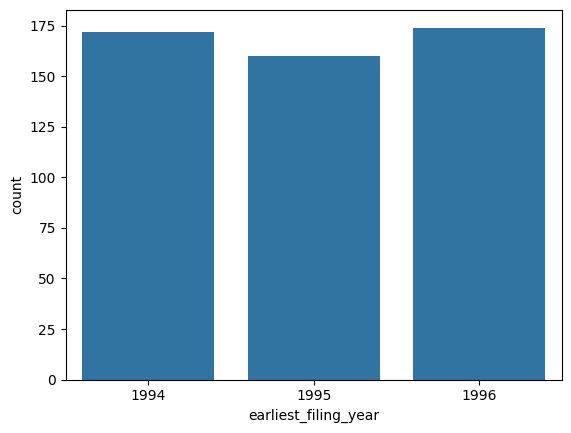

In [ ]:
sns.countplot(x='earliest_filing_year', data=df)

<Axes: xlabel='person_ctry_code', ylabel='count'>

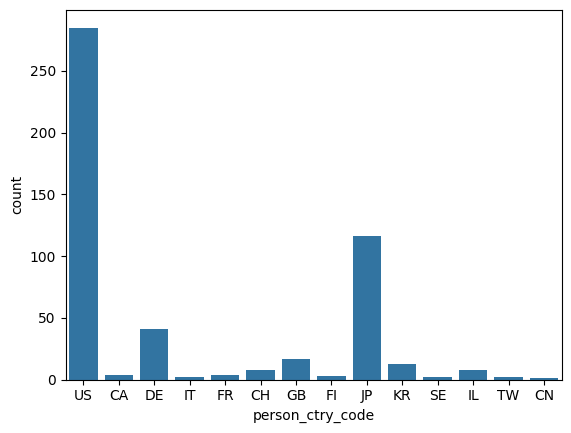

In [ ]:
#sns coutplot for country
sns.countplot(x='person_ctry_code', data=df)

<Axes: xlabel='cpc_class_symbol', ylabel='count'>

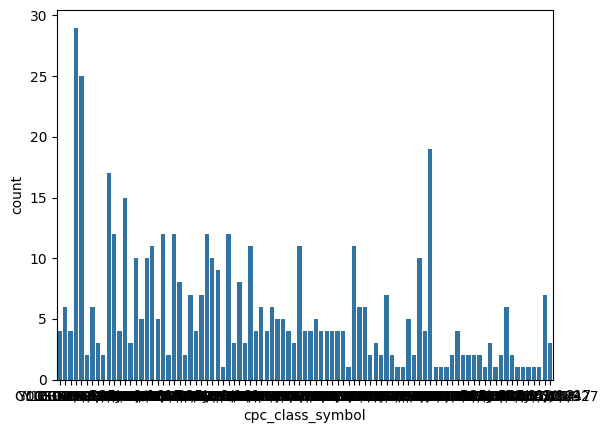

In [ ]:
#sns countplog for cpc_class_symbol
sns.countplot(x='cpc_class_symbol', data=df)

<Axes: xlabel='nace2_code', ylabel='count'>

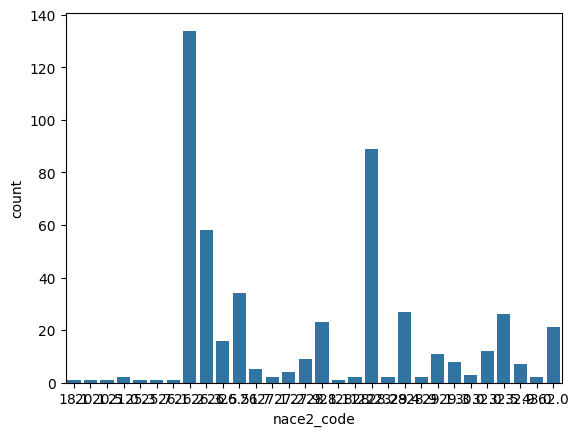

In [ ]:
#sns countplot for nace2_code
sns.countplot(x='nace2_code', data=df)

In [ ]:
# 필요한 컬럼 선택
df = df[['appln_id', 'earliest_filing_year', 'person_ctry_code',
         'cpc_class_symbol', 'nace2_code', 'appln_title', 'appln_abstract']]

# 결측치 확인
print(df.isnull().sum())


appln_id                0
earliest_filing_year    0
person_ctry_code        0
cpc_class_symbol        0
nace2_code              0
appln_title             0
appln_abstract          0
dtype: int64


In [ ]:
# 결측치 처리: title과 abstract는 빈 문자열로, cpc_class_symbol은 제거
df['appln_title'] = df['appln_title'].fillna('')
df['appln_abstract'] = df['appln_abstract'].fillna('')
df = df.dropna(subset=['cpc_class_symbol'])


In [ ]:
df.shape

(506, 7)

In [ ]:
# cpc_class_symbol의 클래스 수 확인
print(df['cpc_class_symbol'].nunique())


91


In [ ]:
# cpc_class_symbol의 클래스 수가 많을 경우, 상위 N개 클래스로 제한하는 것이 모델 학습에 유리할 수 있음
# 상위 N개의 클래스만 선택 (예: 256개 중에서 상위 20개만 선택)
top_n = 20
top_classes = df['cpc_class_symbol'].value_counts().nlargest(top_n).index
df = df[df['cpc_class_symbol'].isin(top_classes)]


In [ ]:
df.shape

(266, 7)

In [ ]:
# 레이블 인코딩을 위한 라이브러리 불러오기
from sklearn.preprocessing import LabelEncoder
import joblib

# 레이블 인코딩 객체 생성
le = LabelEncoder()

# 'cpc_class_symbol' 열을 레이블 인코딩하여 'cpc_class_encoded' 열에 저장
df['cpc_class_encoded'] = le.fit_transform(df['cpc_class_symbol'])

# 인코더 객체를 'label_encoder.joblib' 파일로 저장
joblib.dump(le, 'label_encoder.joblib')

# 'appln_title', 'appln_abstract', 'cpc_class_symbol', 'cpc_class_encoded' 열을 출력하여 결과 확인
print(df[['appln_title', 'appln_abstract', 'cpc_class_symbol', 'cpc_class_encoded']].head())


                                          appln_title  \
4                        Voice interactive sportscard   
7   Method and apparatus for generating and reprod...   
13  Method and device for evaluating an EEG carrie...   
14  Method for replacing parts of a digitally code...   
15  Defuzzification device for a high-resolution f...   

                                       appln_abstract cpc_class_symbol  \
4   A voice interactive sportscard, which through ...      G10L  15/26   
7   PCT No. PCT/EP95/00590 Sec. 371 Date Nov. 5, 1...     G06T   9/005   
13  PCT No. PCT/DE96/01975 Sec. 371 Date Apr. 17, ...    A61B   5/7267   
14  A method for replacing parts of a digitally co...     G06T   9/005   
15  PCT No. PCT/DE95/00946 Sec. 371 Date Jan. 29, ...      Y10S 706/90   

    cpc_class_encoded  
4                  14  
7                  10  
13                  0  
14                 10  
15                 17  


In [ ]:
df.shape

(266, 8)

##**5. 데이터셋 클래스 정의**


**PatentBERT는 BERT 모델을 기반으로 하므로, appln_title과 appln_abstract를 결합하여 입력으로 사용합니다. claims가 없으므로 이 부분은 생략합니다.**


In [ ]:
import torch
from transformers import BertTokenizer

from torch.utils.data import Dataset, DataLoader

# 특허 데이터셋 정의
class PatentDataset(Dataset):
    # 데이터셋 초기화 함수
    def __init__(self, titles, abstracts, labels, tokenizer, max_length):
        self.titles = titles  # 특허 제목 리스트
        self.abstracts = abstracts  # 특허 초록 리스트
        self.labels = labels  # 레이블 리스트
        self.tokenizer = tokenizer  # 토크나이저 (BERT 등)
        self.max_length = max_length  # 최대 토큰 길이 설정

    # 데이터셋 크기 반환
    def __len__(self):
        return len(self.titles)

    # 특정 인덱스에 해당하는 데이터 반환
    def __getitem__(self, idx):
        title = str(self.titles[idx])  # 특허 제목을 문자열로 변환
        abstract = str(self.abstracts[idx])  # 특허 초록을 문자열로 변환
        label = self.labels[idx]  # 해당 데이터의 레이블

        # 제목과 초록을 하나의 텍스트로 결합
        text = title + " " + abstract

        # 토크나이저로 텍스트를 인코딩
        encoding = self.tokenizer.encode_plus(
            text,  # 입력 텍스트
            add_special_tokens=True,  # 특수 토큰 추가 ([CLS], [SEP] 등)
            max_length=self.max_length,  # 최대 길이 설정
            truncation=True,  # 초과된 길이는 자르기
            padding='max_length',  # 최대 길이에 맞춰 패딩
            return_attention_mask=True,  # attention mask 반환
            return_tensors='pt',  # PyTorch 텐서로 반환
        )

        # 인코딩된 데이터와 레이블 반환
        return {
            'input_ids': encoding['input_ids'].flatten(),  # 입력 IDs
            'attention_mask': encoding['attention_mask'].flatten(),  # attention mask
            'labels': torch.tensor(label, dtype=torch.long)  # 레이블 (정수형)
        }


##**6. 모델 초기화 및 학습**


**6.1 데이터 분할**


In [ ]:
from sklearn.model_selection import train_test_split

# 특징(feature) 변수와 타겟(target) 변수 정의
# X: 특허 제목과 초록을 포함하는 입력 데이터 (feature)
# y: CPC 분류를 나타내는 인코딩된 값 (target)
X = df[['appln_title', 'appln_abstract']]  # 특허 제목과 초록을 feature 변수로 선택
y = df['cpc_class_encoded']  # CPC 분류 코드 인코딩을 target 변수로 설정

# 훈련 세트와 테스트 세트로 데이터를 분할
# test_size=0.2: 테스트 세트는 전체 데이터의 20%로 설정
# random_state=42: 무작위 분할의 일관성을 위해 시드 값 고정
# stratify=y: 타겟 변수를 기준으로 훈련/테스트 세트에 균등한 비율로 분포시키기 위함 (층화 추출)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 훈련 데이터와 테스트 데이터의 크기 출력
print(f'Train size: {X_train.shape[0]}')  # 훈련 세트의 샘플 수 출력
print(f'Test size: {X_test.shape[0]}')  # 테스트 세트의 샘플 수 출력


Train size: 212
Test size: 54


**6.2 토크나이저 및 데이터로드 설정**


In [ ]:
# BERT 토크나이저 초기화
# 'bert-base-uncased' 사전 학습된 모델의 토크나이저를 불러옴
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 최대 시퀀스 길이 설정
MAX_LENGTH = 512  # 모델이 처리할 수 있는 최대 토큰 길이 (GPU 메모리에 따라 조정 필요)

# 훈련 데이터셋 생성
train_dataset = PatentDataset(
    titles=X_train['appln_title'].to_numpy(),  # 훈련 세트의 제목을 NumPy 배열로 변환
    abstracts=X_train['appln_abstract'].to_numpy(),  # 훈련 세트의 초록을 NumPy 배열로 변환
    labels=y_train.to_numpy(),  # 훈련 세트의 레이블을 NumPy 배열로 변환
    tokenizer=tokenizer,  # BERT 토크나이저 사용
    max_length=MAX_LENGTH  # 최대 시퀀스 길이 설정
)

# 테스트 데이터셋 생성
test_dataset = PatentDataset(
    titles=X_test['appln_title'].to_numpy(),  # 테스트 세트의 제목을 NumPy 배열로 변환
    abstracts=X_test['appln_abstract'].to_numpy(),  # 테스트 세트의 초록을 NumPy 배열로 변환
    labels=y_test.to_numpy(),  # 테스트 세트의 레이블을 NumPy 배열로 변환
    tokenizer=tokenizer,  # BERT 토크나이저 사용
    max_length=MAX_LENGTH  # 최대 시퀀스 길이 설정
)

# 배치 사이즈 설정
BATCH_SIZE = 8  # 각 배치에서 처리할 샘플 수 (GPU 메모리 한도에 맞춰 조정 가능)

# 훈련 데이터로더 생성
# 배치 사이즈만큼 데이터를 묶어서 모델에 전달하며, 훈련 데이터는 매번 셔플링함
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 테스트 데이터로더 생성
# 테스트 데이터는 셔플링하지 않고 그대로 배치 사이즈만큼 묶어서 모델에 전달
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**6.3 모델 초기화**


In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# 클래스 수 설정 (레이블 인코더로 인코딩된 클래스 수)
num_labels = len(le.classes_)  # 레이블 인코더에서 인코딩된 고유 클래스 수를 가져옴

# BERT 모델 초기화 (시퀀스 분류용)
# 'bert-base-uncased' 사전 학습된 모델을 불러와서 시퀀스 분류 작업에 맞게 설정
# num_labels: 분류할 클래스 수
# output_attentions=False: 어텐션 가중치를 출력하지 않음
# output_hidden_states=False: 히든 스테이트를 출력하지 않음
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

# GPU 사용 설정
# torch.cuda.is_available(): GPU가 사용 가능한지 확인
# 사용 가능하면 'cuda' 장치를, 그렇지 않으면 'cpu' 장치를 사용
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델을 선택된 장치로 이동 (GPU 또는 CPU)
model.to(device)

# 현재 사용 중인 장치 출력 (GPU 또는 CPU)
print(f'Using device: {device}')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


**6.4 옵티마이저 및 스케줄러 설정**


In [ ]:
# 옵티마이저 설정 (AdamW 사용)
# model.parameters(): 모델의 학습 가능한 파라미터들을 옵티마이저에 전달
# lr=2e-5: 학습률(Learning rate)을 2e-5로 설정 (BERT 모델에 적합한 작은 학습률)
# correct_bias=False: Adam 옵티마이저의 편향 수정 여부 (일반적으로 False로 설정)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# 학습할 에포크(Epoch) 수 설정
# EPOCHS: 모델이 전체 훈련 데이터를 학습하는 횟수 (3번 반복)
EPOCHS = 3

# 전체 학습 스텝 수 계산
# len(train_loader): 훈련 데이터의 배치 수
# total_steps: 훈련 세트에서 각 에포크 당 스텝 수 * 에포크 수
total_steps = len(train_loader) * EPOCHS

# 학습률 스케줄러 설정 (선형 스케줄링 사용)
# get_linear_schedule_with_warmup: 학습 초기에는 학습률을 천천히 증가시키고 이후 선형적으로 감소
# optimizer: 학습할 옵티마이저
# num_warmup_steps=0: 워밍업 단계(학습률을 천천히 증가시키는 단계)의 스텝 수 (0이면 워밍업 없이 바로 학습 시작)
# num_training_steps: 전체 학습 스텝 수 (total_steps 값)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**6.5 학습 및 평가 함수 정의**


In [ ]:
from sklearn.metrics import classification_report

# 에포크 동안 모델 학습 함수
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()  # 모델을 학습 모드로 설정 (dropout과 batchnorm이 활성화됨)
    total_loss = 0  # 전체 손실값 초기화

    # 데이터로더에서 배치를 하나씩 가져와 학습
    for batch in data_loader:
        optimizer.zero_grad()  # 옵티마이저의 그래디언트 초기화

        # 배치에서 입력 데이터와 attention mask, 레이블을 가져와서 장치(GPU/CPU)로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 입력 데이터를 전달하여 출력값 및 손실 계산
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss  # 모델의 손실값 가져오기
        total_loss += loss.item()  # 배치 손실을 누적

        loss.backward()  # 손실값을 기준으로 역전파 수행
        optimizer.step()  # 옵티마이저가 파라미터 업데이트
        scheduler.step()  # 스케줄러로 학습률 조정

    avg_loss = total_loss / len(data_loader)  # 평균 손실 계산
    return avg_loss  # 에포크 동안의 평균 손실값 반환

# 모델 평가 함수
def eval_model(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 설정 (dropout과 batchnorm 비활성화)
    predictions = []  # 예측값 저장 리스트
    true_labels = []  # 실제 레이블 저장 리스트

    # 평가 모드에서는 그래디언트 계산 비활성화
    with torch.no_grad():
        for batch in data_loader:
            # 배치에서 입력 데이터와 attention mask, 레이블을 가져와 장치(GPU/CPU)로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 모델에 입력 데이터를 전달하여 로짓(logits) 출력
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits  # 모델의 로짓값 가져오기
            preds = torch.argmax(logits, dim=1).flatten()  # 로짓에서 가장 높은 확률을 가진 클래스 예측

            # 예측값과 실제값을 CPU로 이동하여 리스트에 저장
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels  # 예측값과 실제값 반환


**6.6 모델 학습**


In [ ]:
# 학습 및 평가 반복
for epoch in range(EPOCHS):  # 설정한 에포크 수만큼 반복
    print(f'Epoch {epoch + 1}/{EPOCHS}')  # 현재 에포크 출력
    print('-' * 10)  # 구분선 출력

    # 한 에포크 동안 훈련을 수행하고 훈련 손실을 계산
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f'Train loss: {train_loss}')  # 훈련 손실 출력

    # 테스트 데이터셋에 대해 모델을 평가하고 예측값과 실제값 반환
    preds, labels = eval_model(model, test_loader, device)

    # 예측값과 실제값을 기반으로 분류 성능 평가
    # classification_report: 정확도, 정밀도, 재현율 등의 지표를 계산
    report = classification_report(labels, preds, target_names=le.classes_)
    print(report)  # 성능 평가 결과 출력


Epoch 1/3
----------
Train loss: 2.771621933689824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

 A61B   5/7267       0.00      0.00      0.00         4
   A63F  13/67       0.00      0.00      0.00         2
  B25J   9/161       0.00      0.00      0.00         2
 B25J   9/1615       0.00      0.00      0.00         2
 F16H2061/0081       0.67      1.00      0.80         4
  G05B  13/027       0.00      0.00      0.00         2
 G05D   1/0077       0.00      0.00      0.00         2
  G06N   3/049       0.00      0.00      0.00         2
   G06T   9/00       0.00      0.00      0.00         3
  G06T   9/001       0.00      0.00      0.00         2
  G06T   9/005       0.31      1.00      0.48         5
  G06T   9/007       0.00      0.00      0.00         3
  G06T   9/008       0.00      0.00      0.00         3
   G10L  15/22       0.33      0.50      0.40         2
   G10L  15/26       0.26      1.00      0.41         6
   G10L  17/00       0.00      0.00      0.00         2
H01M   8/04992       1.00      0.50      0.67  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

 A61B   5/7267       0.67      1.00      0.80         4
   A63F  13/67       1.00      1.00      1.00         2
  B25J   9/161       1.00      1.00      1.00         2
 B25J   9/1615       1.00      0.50      0.67         2
 F16H2061/0081       1.00      1.00      1.00         4
  G05B  13/027       1.00      1.00      1.00         2
 G05D   1/0077       1.00      1.00      1.00         2
  G06N   3/049       1.00      0.50      0.67         2
   G06T   9/00       0.00      0.00      0.00         3
  G06T   9/001       0.00      0.00      0.00         2
  G06T   9/005       0.31      1.00      0.48         5
  G06T   9/007       0.00      0.00      0.00         3
  G06T   9/008       0.00      0.00      0.00         3
   G10L  15/22       1.00      0.50      0.67         2
   G10L  15/26       0.75      1.00      0.86         6
   G10L  17/00       1.00      0.50      0.67         2
H01M   8/04992       1.00      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##**7. 모델 평가 및 예측**

**7.1 혼동 행렬 그리기**


<Figure size 2000x2000 with 0 Axes>

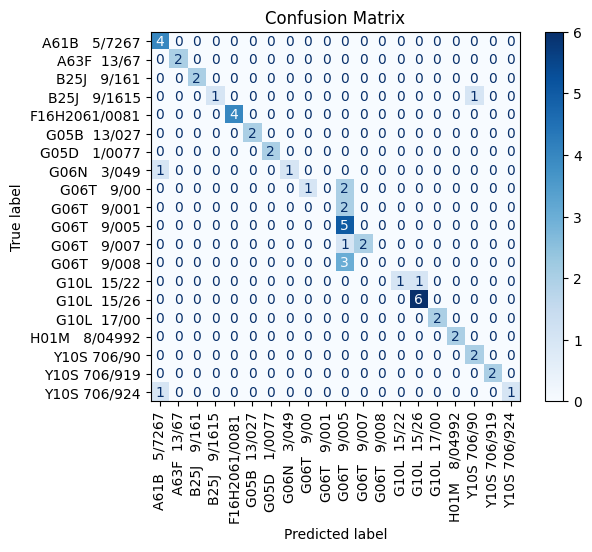

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 혼동 행렬(confusion matrix) 계산
# labels: 실제 레이블
# preds: 모델이 예측한 레이블
cm = confusion_matrix(labels, preds)  # 실제값과 예측값을 비교하여 혼동 행렬 생성

# 혼동 행렬 시각화 객체 생성
# display_labels: 각 클래스의 이름을 표시
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# 혼동 행렬을 시각화하기 위한 플롯 설정
plt.figure(figsize=(20, 20))  # 플롯 크기를 20x20으로 설정 (클래스가 많을 때 가독성 높임)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)  # 행렬을 파란색 컬러맵과 함께 플롯하고, x축 라벨을 90도 회전
plt.title('Confusion Matrix')  # 플롯의 제목 설정
plt.show()  # 플롯을 화면에 표시


True Label (y축): 실제 데이터의 레이블.

Predicted Label (x축): 모델이 예측한 레이블.

대각선 요소: 모델이 올바르게 예측한 값.

비대각선 요소: 잘못된 예측을 나타냄. 예를 들어, G10L 15/22가 G10L 15/26으로 잘못 예측된 경우.

대각선 집중: 대부분의 값이 대각선에 있어, 모델이 많은 클래스를 올바르게 예측함.

오분류: 대각선 외부 값은 잘못된 예측을 의미. 예를 들어, G10L 15/22가 G10L 15/26으로 6번 잘못 예측됨.

G10L 15/26: 6번의 올바른 예측을 했으나, G10L 15/22와 혼동함.

G06T 9/005 및 F16H2061/0081: 예측이 적고, 약간의 오분류 발생. 데이터 부족 또는 구분 어려움 가능성.

소수의 클래스 혼동: A61B 5/7267 및 Y10S 706/919에서 약간의 오분류 발생. 모델 성능은 전반적으로 우수.

**7.2 새로운 특허 문서 분류**


In [ ]:
def predict_category(title, abstract, model, tokenizer, device, label_encoder):
    model.eval()  # 모델을 평가 모드로 설정 (학습 관련 레이어 비활성화)

    # 제목과 초록을 결합하여 입력 텍스트 생성
    text = title + " " + abstract
    # 텍스트를 토크나이저로 인코딩 (BERT 모델에 맞게 처리)
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # [CLS], [SEP] 등의 특수 토큰 추가
        max_length=512,  # 최대 시퀀스 길이 설정
        truncation=True,  # 길이를 초과하면 자름
        padding='max_length',  # 최대 길이에 맞춰 패딩 추가
        return_attention_mask=True,  # attention mask 반환
        return_tensors='pt',  # PyTorch 텐서로 반환
    )

    # 인코딩된 데이터를 GPU/CPU로 이동
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # 그래디언트 계산 없이 예측 수행
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # 모델에 입력 전달
        logits = outputs.logits  # 모델의 예측 결과 (로짓 값)
        preds = torch.argmax(logits, dim=1).flatten()  # 가장 높은 확률의 클래스 예측

    # 예측된 클래스 인덱스를 실제 카테고리 레이블로 변환
    category = label_encoder.inverse_transform(preds.cpu().numpy())
    return category[0]  # 예측된 카테고리 반환

# 예시 특허 문서
new_title = "Innovative Widget Design"  # 새로운 특허 제목
new_abstract = "This patent describes a novel widget that improves efficiency..."  # 새로운 특허 초록

# 예측
predicted_category = predict_category(new_title, new_abstract, model, tokenizer, device, le)
print(f'Predicted Category: {predicted_category}')  # 예측된 카테고리 출력


Predicted Category: G10L  15/26


In [ ]:
from sklearn.metrics import classification_report

# classification_report를 딕셔너리 형태로 생성
report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)

# 딕셔너리를 데이터프레임으로 변환
df_report = pd.DataFrame(report).transpose()

# 상위 N개의 클래스만 사용 (여기서는 20개 클래스)
df_report = df_report.iloc[:20, :3]  # 'accuracy', 'macro avg', 'weighted avg' 제외

# 데이터 확인
print(df_report.head())


               precision  recall  f1-score
A61B   5/7267   0.666667     1.0  0.800000
A63F  13/67     1.000000     1.0  1.000000
B25J   9/161    1.000000     1.0  1.000000
B25J   9/1615   1.000000     0.5  0.666667
F16H2061/0081   1.000000     1.0  1.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 필요한 지표만 추출
df_metrics = df_report[['precision', 'recall', 'f1-score']]

# 데이터 확인
print(df_metrics.head())


               precision  recall  f1-score
A61B   5/7267   0.666667     1.0  0.800000
A63F  13/67     1.000000     1.0  1.000000
B25J   9/161    1.000000     1.0  1.000000
B25J   9/1615   1.000000     0.5  0.666667
F16H2061/0081   1.000000     1.0  1.000000


<Figure size 1500x800 with 0 Axes>

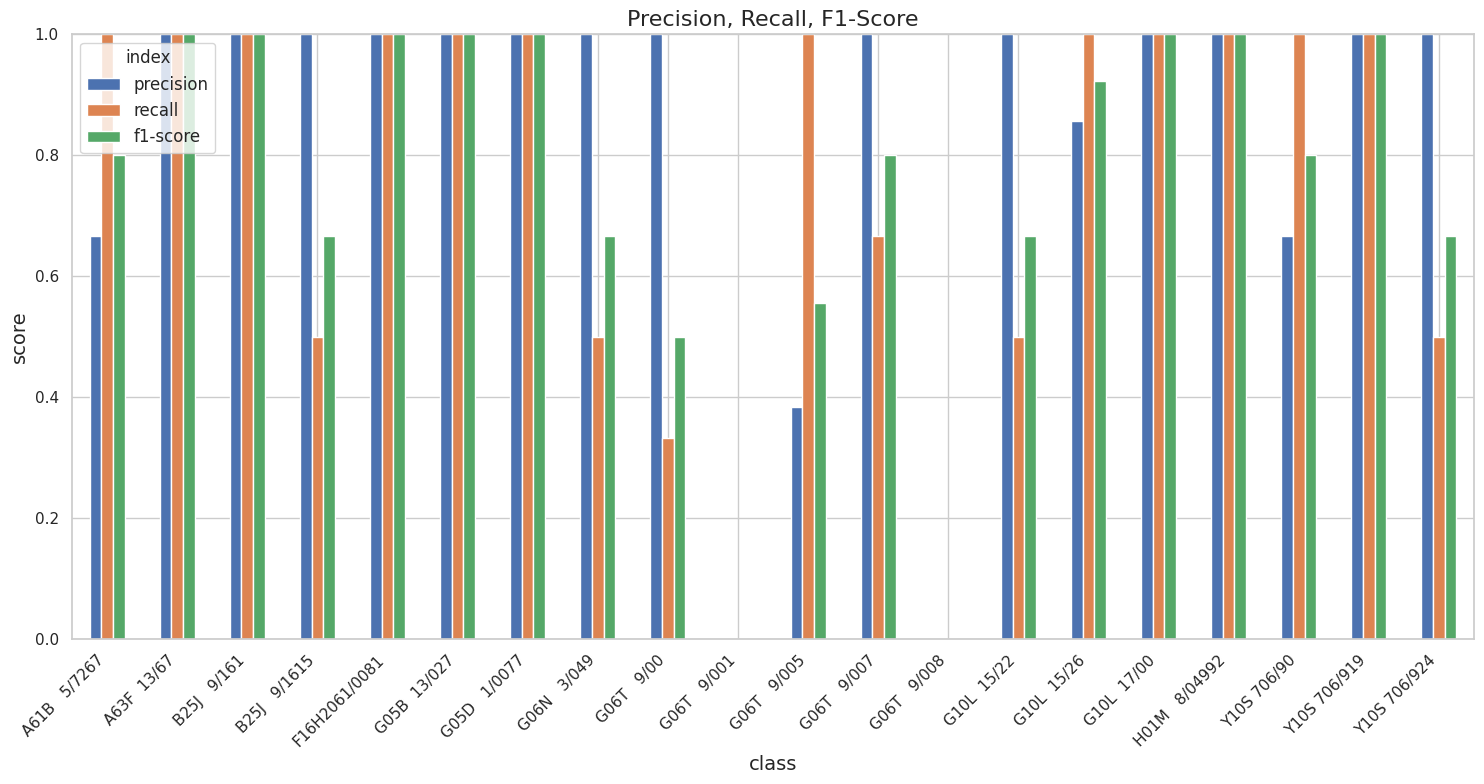

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 크기 설정
plt.figure(figsize=(15, 8))

# 막대 그래프 생성
df_metrics.plot(kind='bar', figsize=(15, 8))

# 그래프 제목 및 축 레이블 설정
plt.title('Precision, Recall, F1-Score', fontsize=16)
plt.xlabel('class', fontsize=14)
plt.ylabel('score', fontsize=14)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')

# y축 범위 설정
plt.ylim(0, 1)

# 범례 위치 설정
plt.legend(title='index', loc='upper left', fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


In [ ]:
# 필요한 라이브러리 임포트 및 설치
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install joblib
!pip install seaborn

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 전처리
data_url = 'https://raw.githubusercontent.com/deep1003/deep1003/master/patent_industry.csv'

# csv 파일을 읽을때 ; 분리
df = pd.read_csv(data_url, sep=';')


# 필요한 컬럼 선택
df = df[['appln_id', 'earliest_filing_year', 'person_ctry_code',
         'cpc_class_symbol', 'nace2_code', 'appln_title', 'appln_abstract']]

# 결측치 처리: 제목과 초록은 빈 문자열로, CPC 분류 심볼이 없는 행은 제거
df['appln_title'] = df['appln_title'].fillna('')
df['appln_abstract'] = df['appln_abstract'].fillna('')
df = df.dropna(subset=['cpc_class_symbol'])

# CPC 분류 심볼 상위 20개로 데이터 제한
top_n = 20
top_classes = df['cpc_class_symbol'].value_counts().nlargest(top_n).index
df = df[df['cpc_class_symbol'].isin(top_classes)]

# 레이블 인코딩: 문자열 레이블을 숫자로 변환
le = LabelEncoder()
df['cpc_class_encoded'] = le.fit_transform(df['cpc_class_symbol'])

# 인코더 저장: 나중에 예측 시 사용
joblib.dump(le, 'label_encoder.joblib')

# 데이터셋 클래스 정의
class PatentDataset(Dataset):
    def __init__(self, titles, abstracts, labels, tokenizer, max_length):
        self.titles = titles
        self.abstracts = abstracts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        title = str(self.titles[idx])
        abstract = str(self.abstracts[idx])
        label = self.labels[idx]

        # 제목과 초록을 결합하여 하나의 텍스트로 만듦
        text = title + " " + abstract

        # 텍스트를 BERT 입력 형식으로 인코딩
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),       # 입력 토큰 ID
            'attention_mask': encoding['attention_mask'].flatten(),  # 어텐션 마스크
            'labels': torch.tensor(label, dtype=torch.long)     # 레이블
        }

# 데이터 분할: 훈련 세트와 테스트 세트로 나눔 (80% 훈련, 20% 테스트)
X = df[['appln_title', 'appln_abstract']]
y = df['cpc_class_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')

# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 최대 시퀀스 길이 설정
MAX_LENGTH = 256  # 필요에 따라 조정 가능

# 데이터셋 생성
train_dataset = PatentDataset(
    titles=X_train['appln_title'].to_numpy(),
    abstracts=X_train['appln_abstract'].to_numpy(),
    labels=y_train.to_numpy(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = PatentDataset(
    titles=X_test['appln_title'].to_numpy(),
    abstracts=X_test['appln_abstract'].to_numpy(),
    labels=y_test.to_numpy(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# 배치 사이즈 설정
BATCH_SIZE = 8  # GPU 메모리에 따라 조정

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 모델 초기화: BERT 기반 분류 모델
num_labels = len(le.classes_)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

# 디바이스 설정: GPU 사용 가능 시 GPU 사용
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(f'Using device: {device}')

# 옵티마이저 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
EPOCHS = 3
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 학습 함수 정의
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()  # 이전 그래디언트 초기화

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 입력 데이터를 전달하고 출력과 손실 계산
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 업데이트
        scheduler.step()  # 스케줄러 업데이트

    avg_loss = total_loss / len(data_loader)  # 평균 손실 계산
    return avg_loss

# 평가 함수 정의
def eval_model(model, data_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []
    true_labels = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 모델에 입력 데이터를 전달하고 출력 받기
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()  # 예측 클래스 추출

            predictions.extend(preds.cpu().numpy())  # 예측값 저장
            true_labels.extend(labels.cpu().numpy())  # 실제 레이블 저장

    return predictions, true_labels

# 모델 학습 및 평가
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # 학습 단계
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f'Train loss: {train_loss}')

    # 평가 단계
    preds, labels = eval_model(model, test_loader, device)
    report = classification_report(labels, preds, target_names=le.classes_)
    print(report)

    # 정확도 계산
    accuracy = accuracy_score(labels, preds)
    print(f'Accuracy: {accuracy:.4f}')


Train size: 212
Test size: 54


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using device: cuda
Epoch 1/3
----------
Train loss: 3.015567258552269


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

 A61B   5/7267       0.00      0.00      0.00         4
   A63F  13/67       0.00      0.00      0.00         2
  B25J   9/161       0.00      0.00      0.00         2
 B25J   9/1615       0.00      0.00      0.00         2
 F16H2061/0081       0.00      0.00      0.00         4
  G05B  13/027       0.00      0.00      0.00         2
 G05D   1/0077       0.00      0.00      0.00         2
  G06N   3/049       0.00      0.00      0.00         2
   G06T   9/00       0.00      0.00      0.00         3
  G06T   9/001       0.00      0.00      0.00         2
  G06T   9/005       0.00      0.00      0.00         5
  G06T   9/007       0.00      0.00      0.00         3
  G06T   9/008       0.00      0.00      0.00         3
   G10L  15/22       0.00      0.00      0.00         2
   G10L  15/26       0.11      1.00      0.20         6
   G10L  17/00       0.00      0.00      0.00         2
H01M   8/04992       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

 A61B   5/7267       1.00      0.50      0.67         4
   A63F  13/67       0.00      0.00      0.00         2
  B25J   9/161       1.00      1.00      1.00         2
 B25J   9/1615       0.00      0.00      0.00         2
 F16H2061/0081       0.36      1.00      0.53         4
  G05B  13/027       1.00      0.50      0.67         2
 G05D   1/0077       0.67      1.00      0.80         2
  G06N   3/049       0.00      0.00      0.00         2
   G06T   9/00       0.00      0.00      0.00         3
  G06T   9/001       0.00      0.00      0.00         2
  G06T   9/005       0.33      1.00      0.50         5
  G06T   9/007       0.00      0.00      0.00         3
  G06T   9/008       0.00      0.00      0.00         3
   G10L  15/22       0.00      0.00      0.00         2
   G10L  15/26       0.35      1.00      0.52         6
   G10L  17/00       0.00      0.00      0.00         2
H01M   8/04992       1.00      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-32-e0afd08c8800>:34: UserWarning: 

<Figure size 1500x800 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

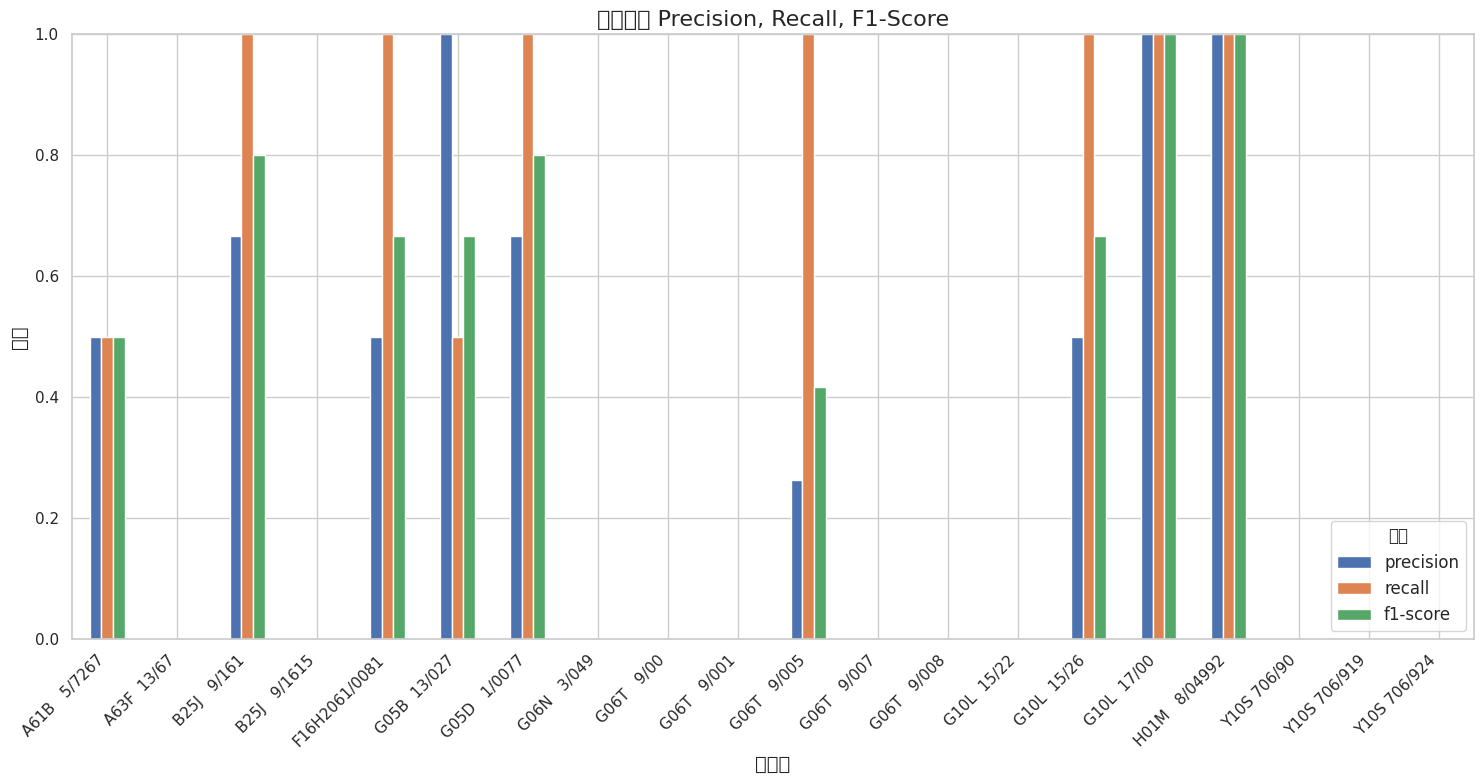

In [ ]:
# classification_report를 딕셔너리 형태로 생성
report_dict = classification_report(labels, preds, target_names=le.classes_, output_dict=True)

# 딕셔너리를 데이터프레임으로 변환
df_report = pd.DataFrame(report_dict).transpose()

# 상위 20개 클래스의 precision, recall, f1-score 추출
df_metrics = df_report.iloc[:20, :3]  # 'accuracy', 'macro avg', 'weighted avg' 제외

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 크기 설정
plt.figure(figsize=(15, 8))

# 막대 그래프 생성
df_metrics.plot(kind='bar', figsize=(15, 8))

# 그래프 제목 및 축 레이블 설정
plt.title('클래스별 Precision, Recall, F1-Score', fontsize=16)
plt.xlabel('클래스', fontsize=14)
plt.ylabel('점수', fontsize=14)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')

# y축 범위 설정
plt.ylim(0, 1)

# 범례 위치 및 제목 설정
plt.legend(title='지표', loc='lower right', fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyp

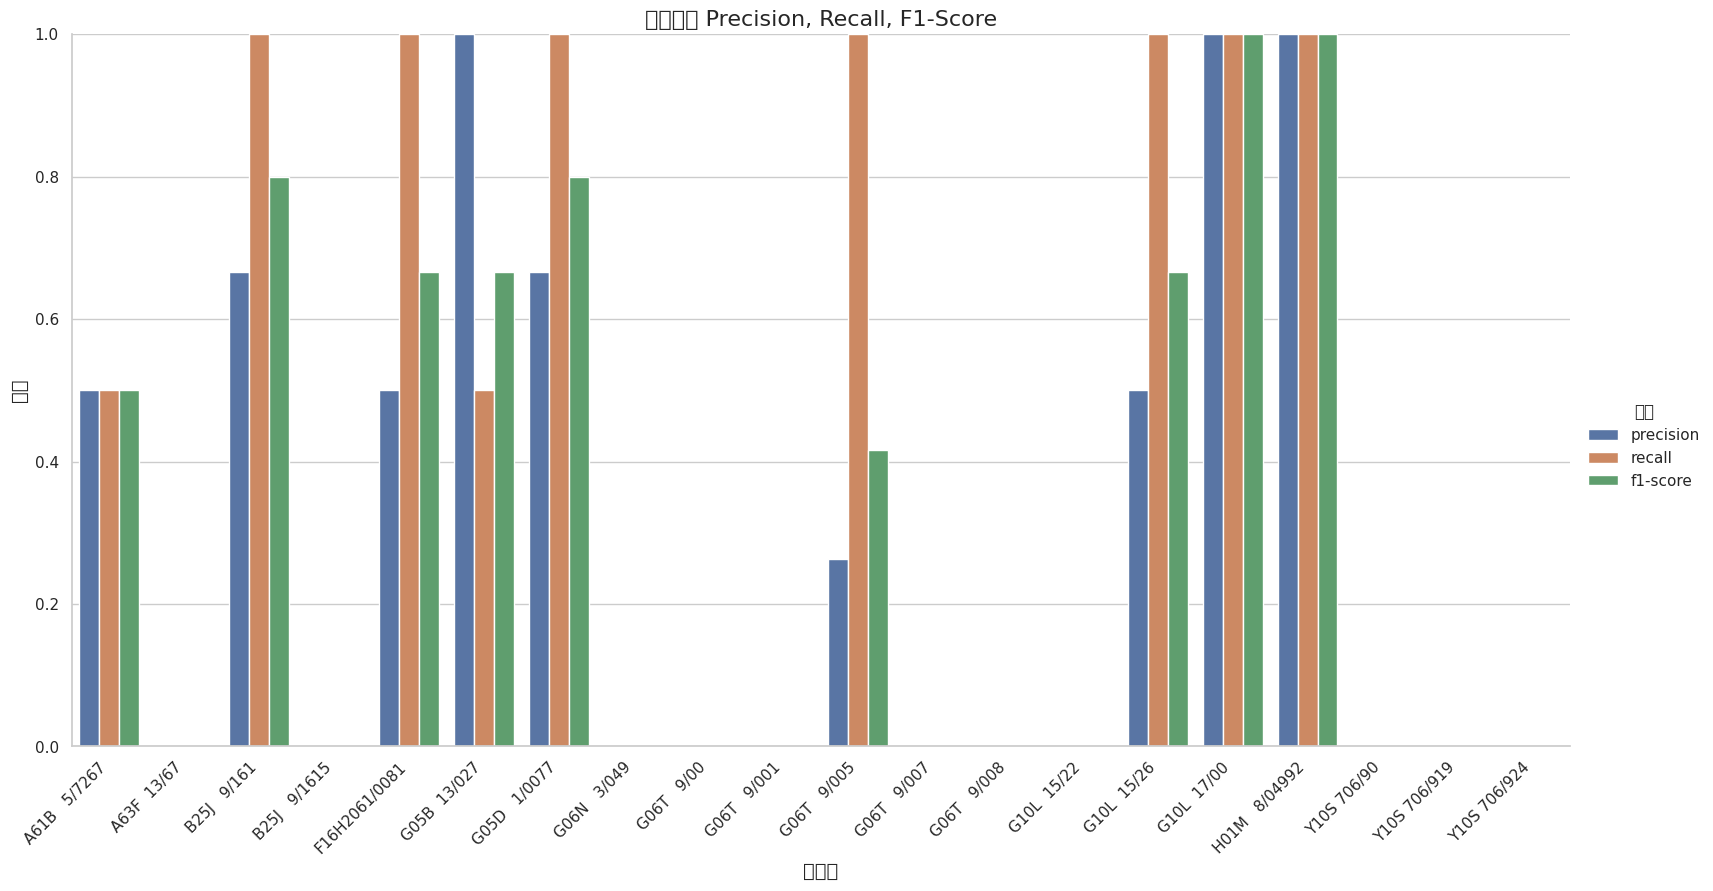

In [ ]:
# 데이터프레임 재구성
df_metrics = df_metrics.reset_index().melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'])
df_metrics.rename(columns={'index': '클래스', 'variable': '지표', 'value': '점수'}, inplace=True)

# Seaborn의 catplot 사용
sns.catplot(x='클래스', y='점수', hue='지표', data=df_metrics, kind='bar', height=8, aspect=2)

# 그래프 제목 설정
plt.title('클래스별 Precision, Recall, F1-Score', fontsize=16)

# 레이블 설정
plt.xlabel('클래스', fontsize=14)
plt.ylabel('점수', fontsize=14)

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')

# y축 범위 설정
plt.ylim(0, 1)

# 그래프 출력
plt.show()


In [ ]:
# 새로운 특허 문서 분류 함수 정의
def predict_category(title, abstract, model, tokenizer, device, label_encoder):
    model.eval()  # 모델을 평가 모드로 설정

    # 제목과 초록을 결합
    text = title + " " + abstract
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()  # 예측 클래스 추출

    category = label_encoder.inverse_transform(preds.cpu().numpy())  # 숫자 레이블을 문자열로 변환
    return category[0]

# 예시 특허 문서
new_title = "Innovative Widget Design"
new_abstract = "This patent describes a novel widget that improves efficiency..."

# 예측
predicted_category = predict_category(new_title, new_abstract, model, tokenizer, device, le)
print(f'Predicted Category: {predicted_category}')


Predicted Category: G10L  15/26


In [ ]:
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(labels, preds)


In [ ]:
import pandas as pd

# 혼동 행렬을 데이터프레임으로 변환
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# 데이터프레임 확인
print(cm_df)


                A61B   5/7267  A63F  13/67  B25J   9/161  B25J   9/1615  \
A61B   5/7267               2            0             0              0   
A63F  13/67                 0            0             0              0   
B25J   9/161                0            0             2              0   
B25J   9/1615               0            0             1              0   
F16H2061/0081               0            0             0              0   
G05B  13/027                0            0             0              0   
G05D   1/0077               0            0             0              0   
G06N   3/049                1            0             0              0   
G06T   9/00                 0            0             0              0   
G06T   9/001                0            0             0              0   
G06T   9/005                0            0             0              0   
G06T   9/007                0            0             0              0   
G06T   9/008             

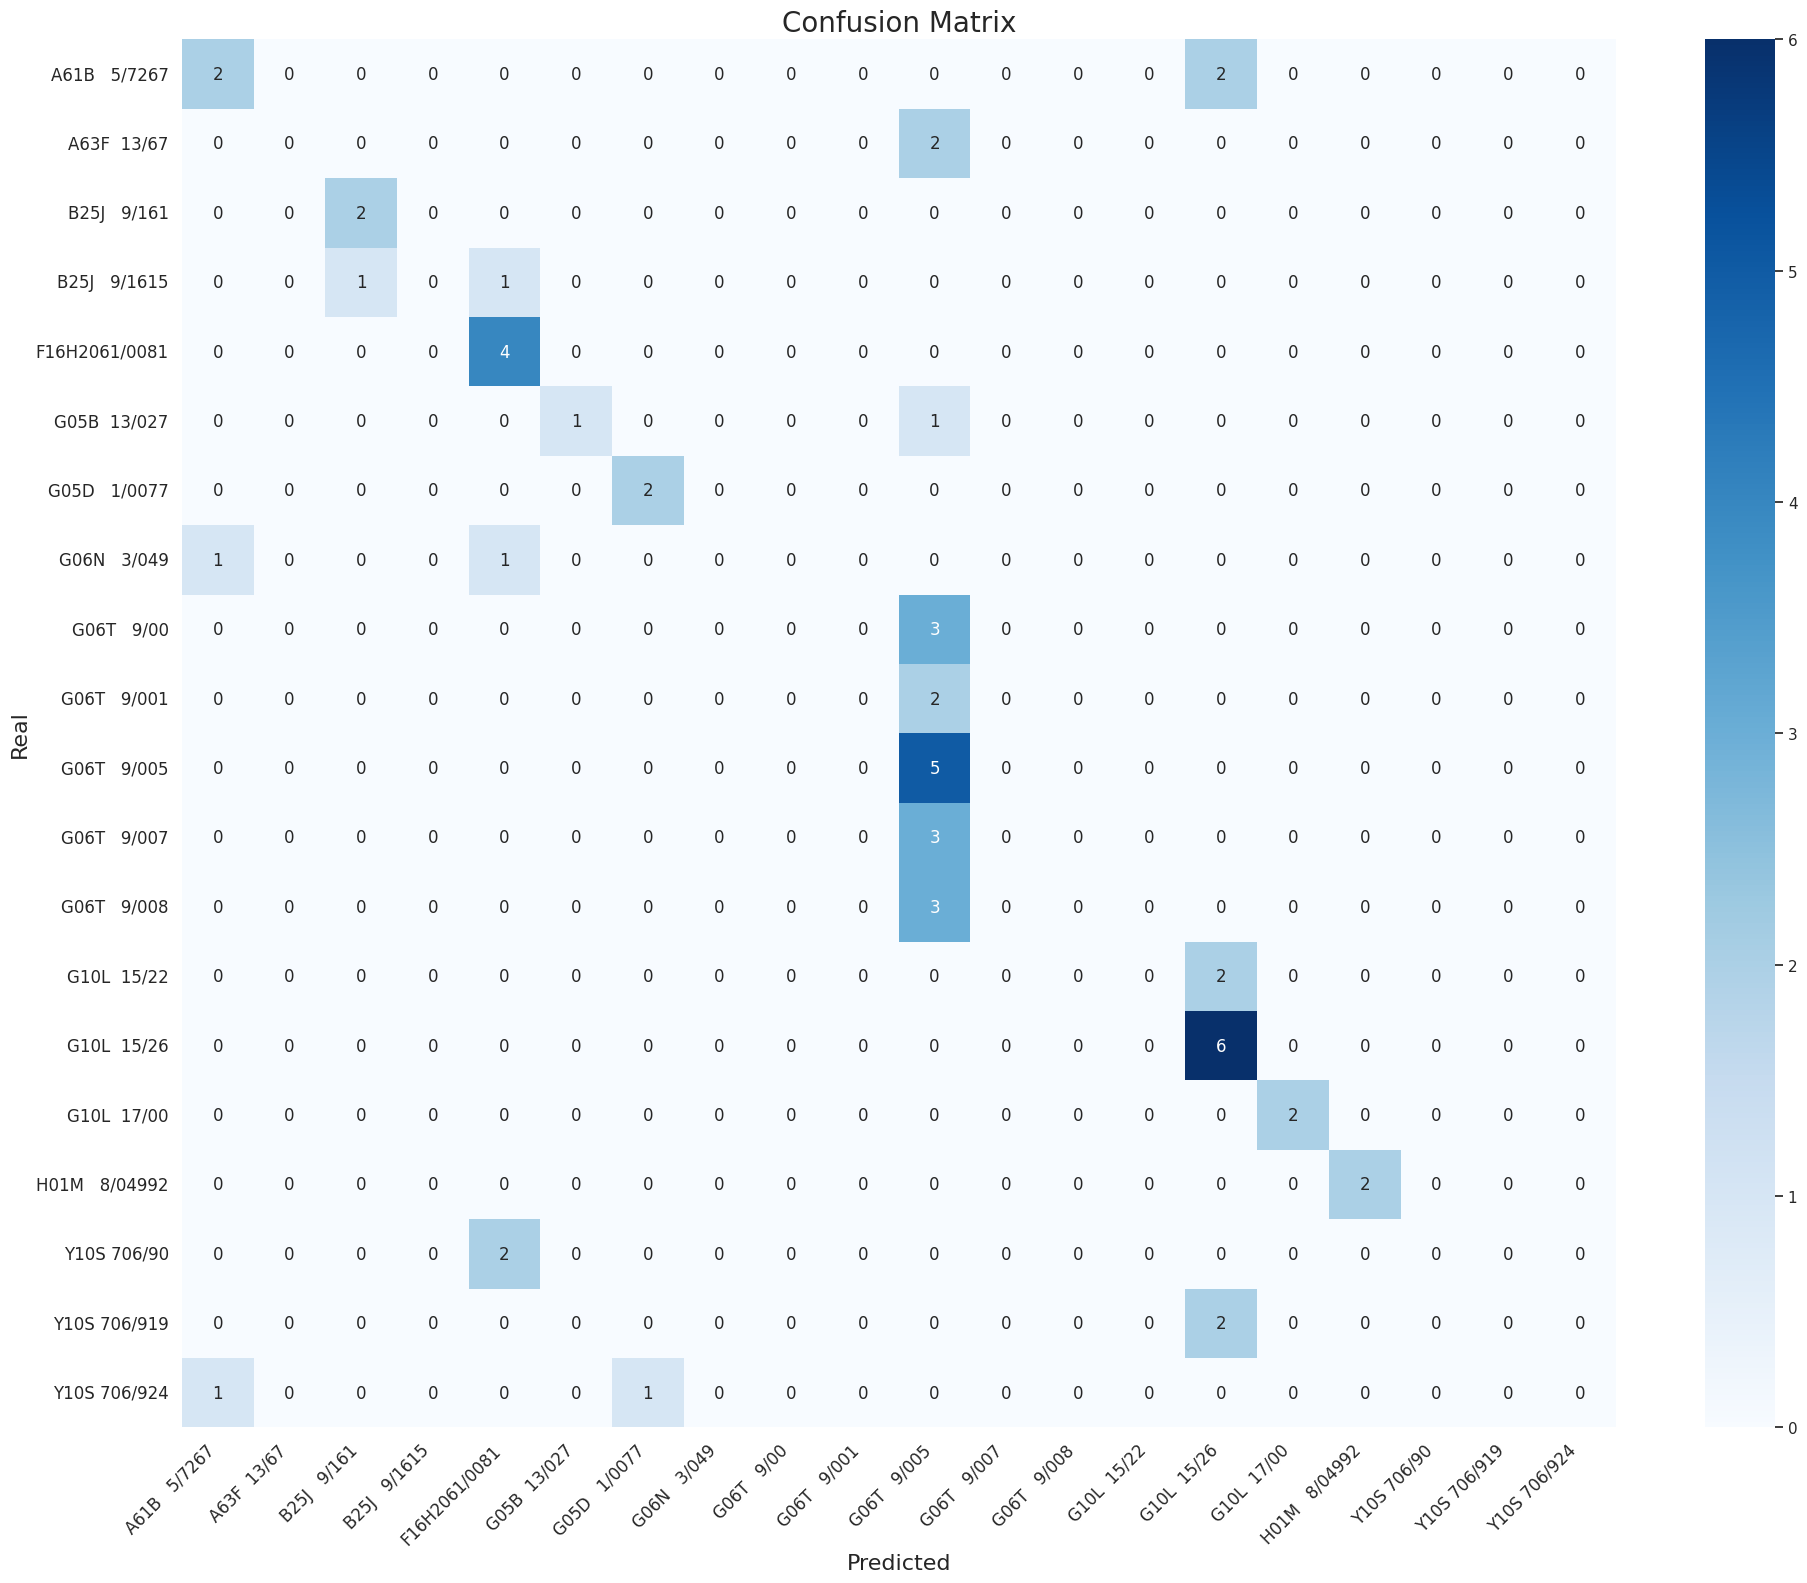

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 크기 설정 (클래스 수에 따라 조정 가능)
plt.figure(figsize=(20, 16))

# 히트맵 생성
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# 그래프 제목 및 축 레이블 설정
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)

# x축 레이블 회전 (가독성 향상)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()
